# Imports

In [65]:
# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import figure_names
from eigenestimation.toy_models.tms import AutoencoderSymmetric, AutoencoderParallel  # Import your model
from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss


from importlib import reload
reload(figure_names)

<module 'figure_names' from '/root/eigenestimation/notebooks/figure_names.py'>

# Initial TMS Model

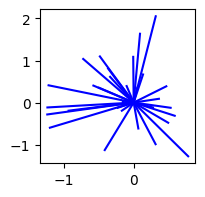

In [66]:
# Load TMS model
model_path = "../outputs/toy_models/high_rank_circuits.pt"
eigenmodel_path = "../outputs/eigenmodels/high_rank_circuits.pt"
checkpoint = torch.load(eigenmodel_path)
model = torch.load(model_path)['model']
eigenmodel = torch.load(eigenmodel_path)['model']
# Plot TMS representations.
en = copy.deepcopy(model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

<Axes: title={'center': 'subnetwork sum'}>

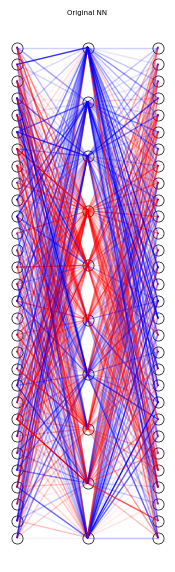

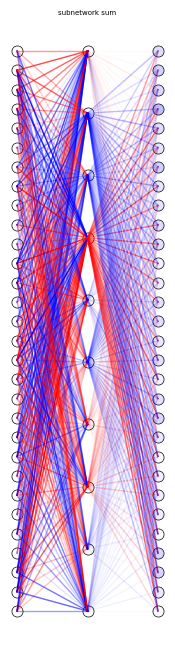

In [67]:
# Load TMS model
model_params = dict(model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2,7))
DrawNeuralNetwork(weights, biases, "Original NN", ax=ax)


model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2,8))
DrawNeuralNetwork(weights, biases, title='subnetwork sum', ax=ax)


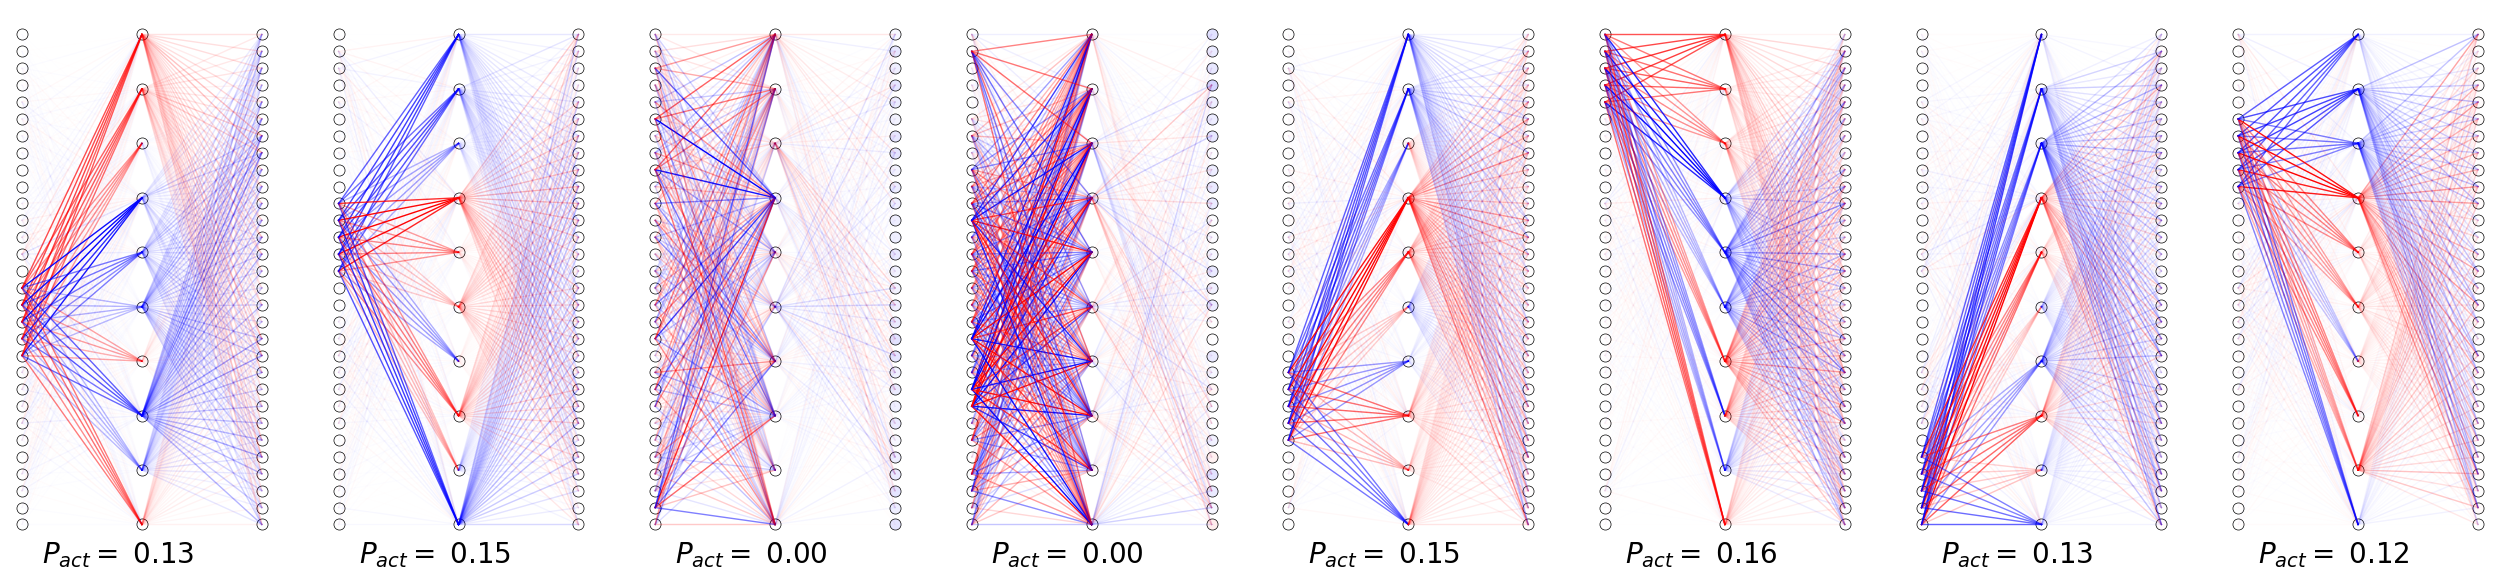

In [68]:
figs = []
f, axes = plt.subplots(figsize=(4*(eigenmodel.n_features),7), nrows=1, ncols=(eigenmodel.n_features))
axes_flat = axes.flatten()
frac_activated = torch.load(eigenmodel_path)['frac_activated']
for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    DrawNeuralNetwork(weights, biases, ax=axes_flat[i])
    axes_flat[i].text(1.8,.05, s=f'$P_{{act}}=$ {frac_activated[i]:.2f}', size=20, ha='center', va='center')
# Save as high_rank_subnetwork_{i}.svg
f.savefig(figure_names.high_rank_circuits_decomposition, transparent=True, bbox_inches='tight')
plt.show()

-----


# Looking at various ranks


TypeError: 'NoneType' object is not subscriptable

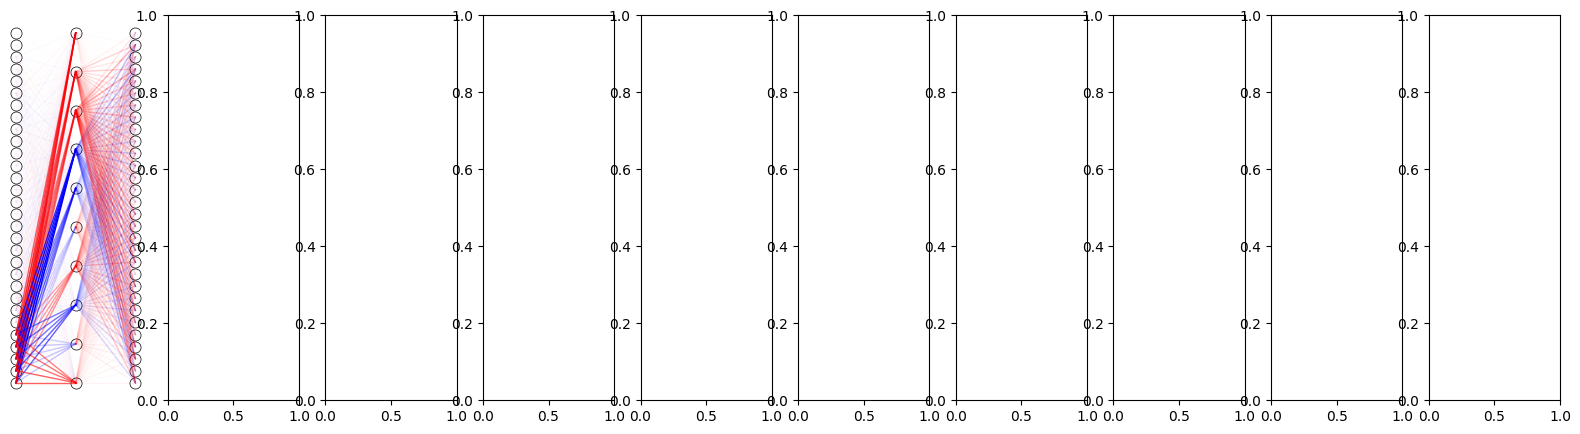

In [71]:
for rank_i in range(1,7):
    eigenmodel_path = f"../outputs/eigenmodels/high_rank_circuits_rank{rank_i}.pt"
    eigenmodel = torch.load(eigenmodel_path)['model']
    f, axes = plt.subplots(figsize=(2*eigenmodel.n_features, 5), ncols=eigenmodel.n_features)
    axes_flat = axes.flatten()
    frac_activated = torch.load(eigenmodel_path)['frac_activated']
    for i, network in enumerate(eigenmodel.construct_subnetworks()):
        weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
        weights = {str(i):v for i,v in enumerate(weights.values())}

        biases = {k:v for k,v in network.items() if 'b' in k}
        biases = {str(i+1):v for i,v in enumerate(biases.values())}

        DrawNeuralNetwork(weights, biases, ax=axes_flat[i])
        axes_flat[i].text(1.8,.05, s=f'$P_{{act}}=$ {frac_activated[i]:.2f}', size=12, ha='center', va='center')
    # Save as high_rank_subnetwork_{i}.svg
    plt.suptitle(f'Rank {rank_i}')
    f.savefig(figure_names.high_rank_decompositions_different_ranks % rank_i, transparent=True, bbox_inches='tight')

In [ ]:
# Get loss metrics from a wandb run
import wandb
import pandas as pd

plt.figure(figsize=(5, 3))
for i in range(1, 9):
    project_path = f"brianna-chrisman-2024/high-rank-circuits-eigenmodel-rank{i}"  # entity/project
    api = wandb.Api()

    #project_path = f"brianna-chrisman-2024/tms-eigenmodel"  # entity/project
    runs = api.runs(project_path)

    # Get the latest run (first in the list)
    latest_run = runs[len(runs)-1]

    # Convert history (logged metrics) to a DataFrame
    history = latest_run.history()


    # Filter only loss metrics (adjust based on your naming convention)
    loss_columns = 'train/loss'
    loss_metrics = history[loss_columns]  # Include step count
    epochs = history['epoch']  # Include step count
    epochs = epochs[loss_metrics.notna()]
    loss_metrics = loss_metrics[loss_metrics.notna()]
    plt.plot(epochs, loss_metrics, label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Rank')
plt.xlabel('Epoch')
plt.ylabel('Loss', rotation=0, labelpad=15)
plt.tight_layout()
plt.savefig(figure_names.high_rank_circuits_loss_vs_rank, transparent=True, bbox_inches='tight')
plt.show()